# **Subtask 2**: Semantic type of premise classification

This Notebook contains all the code that was used for the task of semantic type of premise identification

Please note that currently this notebook is setup to obtain results on our own annotated test set for this task. This means that the variable <i>original_annotations</i> is set to <b>False</b>

Other prompt templates that we experimented with can be found in the <i>prompt templates</i> notebook

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Use our own annotations and initialize GPT-NEO model and tokenizer
original_annotations = False
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
# Validation set that was used for prompt template engineering
val_sents = ["Another reason for my opinion is that CoD doesn't really have anything astoundingly different from other games of the same genre.",
             "So why would a bunch of social outcasts who get made fun of encourage hate and let such raw emotion reign supreme?",
             "a large part of this view came from something a history teacher told me 6 years ago: \"Geography Determines Destiny\", and that quote has stuck with me",
             "I am an omnivore, and my diet consists of meat and plants.",
             "Saying these people shouldn’t be allowed to become part of the country, is the same as saying they are worse,",
             "Every middle-class child in the country would receive a lower quality education if there were 55 million more around",
             "Why do I feel like chasing after girls and getting to know them when I have so many great guy friends already who I know care about me so much more?",
             "you'll still probably feel attraction for other people",
             "their chances of getting shot would also increase"]

val_types = ['Ethos',
             'Pathos',
             'Ethos',
             'Ethos',
             'Pathos',
             'Logos',
             'Logos',
             'Pathos',
             'Logos']

val_tuples = list(zip(val_sents, val_types))
df_val = pd.DataFrame(val_tuples, columns=['Premise','Type']) 

In [ ]:
# Initialize test set
df = pd.read_csv('../data/subtask-2/gold_test.csv', index_col=0)

In [ ]:
# GPT-NEO to fill out the prompt
neo_predictions = []
for premise in df['premise'].to_list():
    if original_annotations:
        prompt = (f"""Premise: Therefore, there will always be a market for meat and other animal products
            Type: logos_pathos
            ###
            Premise: How often do we get to go back and correct our mistakes in real life, anyway?
            Type: logos_pathos
            ###
            Premise: I'l begin by saying it has never happened to me
            Type: ethos
            ###
            Premise: Individuals who are extraordinarily qualified for a position but come from a region/social background without those connections enter a networking-friendly employment opportunity at a disadvantage.
            Type: logos_pathos
            ###
            Premise: I'm an immigrant and a Muslim neither of which is or should be a deterrent from joining
            Type: ethos
            ###
            Premise: how many of these women wouldn't be having financial troubles if there wasn't competition from cheap illegal labor to keep wages lower
            Type: logos_pathos
            ###
            Premise: {premise}
            Type:"""
        )
    else:
        # 1. Logos, 2. Pathos, 3. Ethos
        prompt = (f"""Premise: How often do we get to go back and correct our mistakes in real life, anyway?
            Type: 2
            ###
            Premise: Therefore, there will always be a market for meat and other animal products
            Type: 1
            ###
            Premise: I'l begin by saying it has never happened to me
            Type: 3
            ###
            Premise: Individuals who are extraordinarily qualified for a position but come from a region/social background without those connections enter a networking-friendly employment opportunity at a disadvantage.
            Type: 1
            ###
            Premise: I'm an immigrant and a Muslim neither of which is or should be a deterrent from joining
            Type: 3
            ###
            Premise: how many of these women wouldn't be having financial troubles if there wasn't competition from cheap illegal labor to keep wages lower
            Type: 2
            ###
            Premise: {premise}
            Type:"""
        )

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    gen_tokens = model.generate(
        input_ids,
        temperature=0.8,
        min_length=1,
        length_no_input=True,
        end_sequence='\n###',
        remove_end_sequence=True,
        remove_input=True
    )

    gen_text = tokenizer.batch_decode(gen_tokens)[0]
    # Remove input prompt from the output
    strs = gen_text.replace(prompt,"")
    neo_predictions.append(strs.strip())

if original_annotations:
    df['neo_pred_original'] = neo_predictions
else:
    df['neo_pred'] = neo_predictions

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
ethos        &       0.00 &    0.00 &      0.00 &     23.0 \\
logos        &       0.49 &    1.00 &      0.66 &     41.0 \\
pathos       &       0.00 &    0.00 &      0.00 &     19.0 \\
accuracy     &       0.49 &    0.49 &      0.49 &      0.0 \\
macro avg    &       0.16 &    0.33 &      0.22 &     83.0 \\
weighted avg &       0.24 &    0.49 &      0.33 &     83.0 \\
\bottomrule
\end{tabular}



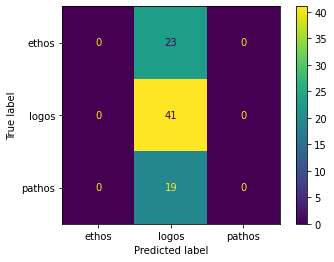

In [ ]:
# Report on gold labels and predictions, showing classification report and
# confusion matrix
def report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame.from_dict(report).transpose().round({'precision': 2, 'recall': 2, 'f1-score': 2, 'support': 0})
    print(df_report.to_latex())
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

# ORIGINAL ANNOTATIONS
if original_annotations:
    df['neo_pred_original'].replace({'logos': 'logos_pathos', 'pathos': 'logos_pathos'}, inplace=True)
    y_true = df['type'].to_list()
    y_pred = df['neo_pred_original'].to_list()
    report(y_true, y_pred)

# OUR ANNOTATIONS
else:
    repl_dict = {'1': 'logos', '2': 'pathos', '3': 'ethos'}
    df['neo_pred'] = df['neo_pred'].map(repl_dict)
    y_true = df['gold'].to_list()
    y_pred = df['neo_pred'].to_list()
    report(y_true, y_pred)